In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
hourly=pd.read_csv('SeattleBike-master/FremontHourly.csv',index_col='Date',parse_dates=True)
hourly.columns=['northbound','southbound']
hourly['total']=hourly['northbound']+hourly['southbound']

In [3]:
daily=hourly.resample('d').sum()
weekly=daily.resample('w').sum()

Text(0, 0.5, 'Weekly riders')

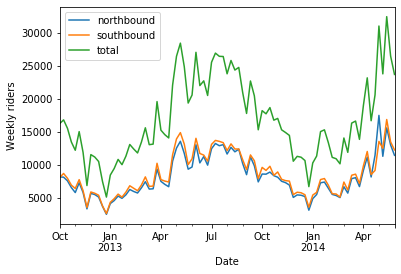

In [4]:
weekly[['northbound','southbound','total']].plot()
plt.ylabel('Weekly riders')

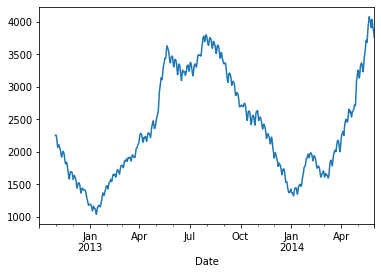

In [5]:
daily['total'].rolling(30).mean().plot()

## Accounting for hours of daylight

In [4]:
import datetime as dt
def hours_of_daylight(date,axis=23.44,latitude=47.61):
    diff=date-dt.datetime(2000,12,21)
    day=diff.total_seconds()/24./3600
    day%=365.25
    m=1.-np.tan(np.radians(latitude))*np.tan(np.radians(axis)
                                             *np.cos(day*np.pi/182.625))
    m=max(0,min(m,2))
    return 24.*np.degrees(np.arccos(1-m))/180

weekly['daylight']=list(map(hours_of_daylight,weekly.index))
daily['daylight']=list(map(hours_of_daylight,daily.index))

Text(0, 0.5, 'hours of daylight(Seattle)')

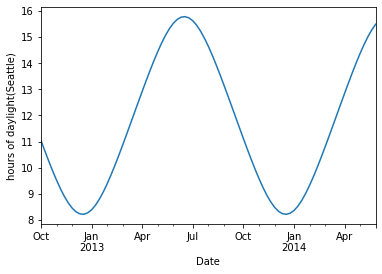

In [7]:
weekly['daylight'].plot()
plt.ylabel('hours of daylight(Seattle)')

Text(0, 0.5, 'weekly bicycle traffic')

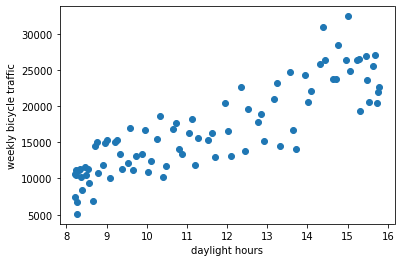

In [8]:
plt.scatter(weekly['daylight'],weekly['total'])
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic')

Text(0, 0.5, 'weekly bicycle traffic')

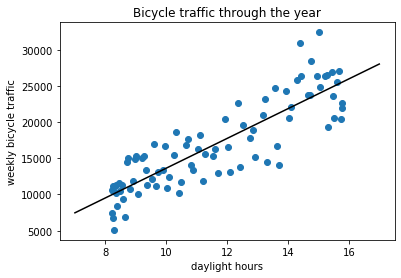

In [9]:
from sklearn.linear_model import LinearRegression

X=weekly[['daylight']]
y=weekly['total']
clf=LinearRegression(fit_intercept=True).fit(X,y)

weekly['daylight_trend']=clf.predict(X)
weekly['daylight_corrected_total']=weekly['total']-weekly['daylight_trend']+weekly['daylight_trend'].mean()
    
xfit=np.linspace(7,17)
yfit=clf.predict(xfit[:,np.newaxis])
plt.scatter(weekly['daylight'],weekly['total'])
plt.plot(xfit,yfit,'-k')
plt.title('Bicycle traffic through the year')
plt.xlabel('daylight hours')
plt.ylabel('weekly bicycle traffic')

In [10]:
clf.coef_[0]

2056.4496498945346

Text(0, 0.5, 'adjusted weekly count')

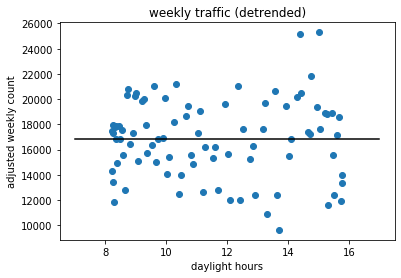

In [11]:
trend=clf.predict(weekly[['daylight']])
plt.scatter(weekly['daylight'],weekly['total']-trend+np.mean(trend))
plt.plot(xfit,np.mean(trend)+0*yfit,'-k')
plt.title('weekly traffic (detrended)')
plt.xlabel('daylight hours')
plt.ylabel('adjusted weekly count')

Text(0, 0.5, 'total weekly riders')

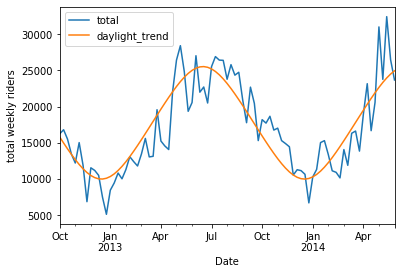

In [12]:
weekly[['total', 'daylight_trend']].plot()
plt.ylabel("total weekly riders")

root-mean-square about trend: 3100 riders


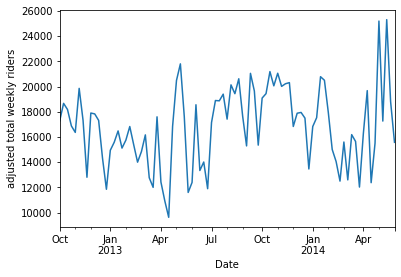

In [13]:
weekly['daylight_corrected_total'].plot()
rms=np.std(weekly['daylight_corrected_total'])
plt.ylabel('adjusted total weekly riders')
print('root-mean-square about trend: {0:.0f} riders'.format(rms))

## Accounting for Day of the Week

In [5]:
days=['Mon','Tues','Wed',"Thurs",'Fri','Sat','Sun']
daily['dayofweek']=daily['total'].index.dayofweek

Text(0, 0.5, 'Average Daily Crossings')

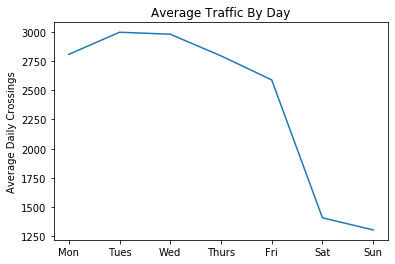

In [13]:
grouped=daily.groupby('dayofweek')['total'].mean()
grouped.index=days

grouped.plot()
plt.title('Average Traffic By Day')
plt.ylabel('Average Daily Crossings')

In [12]:
for i in range(7):
    daily[days[i]]=(daily.index.dayofweek==i).astype(float)
    
X=daily[days+['daylight']]
y=daily['total']
clf=LinearRegression().fit(X,y)

daily['dayofweek_trend']=clf.predict(X)
daily[['total','dayofweek_trend']].plot()

NameError: name 'LinearRegression' is not defined

rms=698


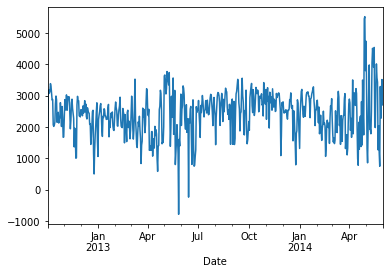

In [17]:
daily['dayofweek_corrected']=(daily['total']-daily['dayofweek_trend']
                              +daily['dayofweek_trend'].mean())
print('rms={0:.0f}'.format(np.std(daily['dayofweek_corrected'])))
daily['dayofweek_corrected'].plot()

## Accounting for Temperature and Precipitation

In [7]:
# load the weather data
weather=pd.read_csv('SeattleBike-master/SeaTacWeather.csv',
                    index_col='DATE',parse_dates=True,usecols=[2,3,6,7])

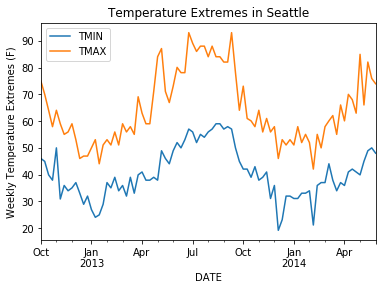

In [8]:
# temperatures are in 1/10 deg C; convert to F
weather['TMIN']=0.18*weather['TMIN']+32
weather['TMAX']=0.18*weather['TMAX']+32

# precip is in 1/10 mm; convert to inches
weather['PRCP']/=254

weather['TMIN'].resample('w').min().plot()
weather['TMAX'].resample('w').max().plot()
plt.ylabel('Weekly Temperature Extremes (F)')
plt.title('Temperature Extremes in Seattle')
plt.legend(loc='best')

Text(0.5, 1.0, 'Precipitation in Seattle')

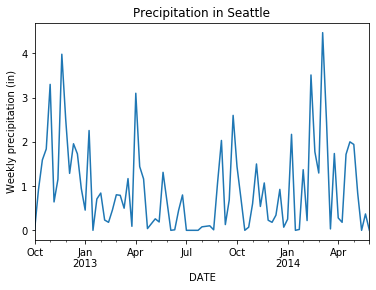

In [9]:
weather['PRCP'].resample('w').sum().plot()
plt.ylabel('Weekly precipitation (in)')
plt.title('Precipitation in Seattle')

In [10]:
# join the weather data to our daily data
daily=daily.join(weather)

In [14]:
columns=days+['daylight','TMIN','TMAX','PRCP']

X=daily[columns]
y=daily['total']
clf=LinearRegression().fit(X,y)
daily['overall_trend']=clf.predict(X)

daily[['total','overall_trend']].plot()
plt.ylabel('Daily bicycle traffic')

NameError: name 'LinearRegression' is not defined

rms=520


Text(0, 0.5, 'corrected daily bicycle traffic')

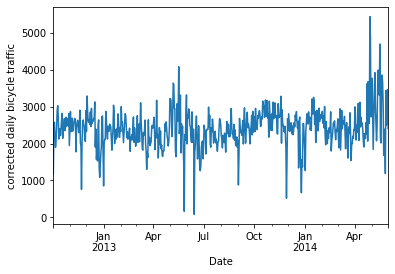

In [23]:
daily['overall_corrected']=daily['total']-daily['overall_trend']+daily['overall_trend'].mean()
print('rms={0:.0f}'.format(np.std(daily['overall_corrected'])))
daily['overall_corrected'].plot()
plt.ylabel('corrected daily bicycle traffic')

Text(0.5, 1.0, '1-month Moving Window Average')

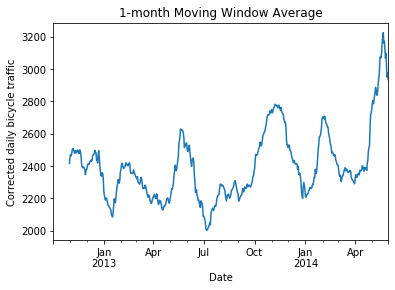

In [24]:
daily['overall_corrected'].rolling(30).mean().plot()
plt.ylabel('Corrected daily bicycle traffic')
plt.title('1-month Moving Window Average')

## Accounting for a Steady Increase or Decrease of Riders

In [26]:
daily['daycount']=np.arange(len(daily))

columns=days+['daycount','daylight','TMIN','TMAX','PRCP']
X=daily[columns]
y=daily['total']
final_model=LinearRegression().fit(X,y)
daily['final_trend']=final_model.predict(X)

daily['final_corrected']=daily['total']-daily['final_trend']+daily['final_trend'].mean()

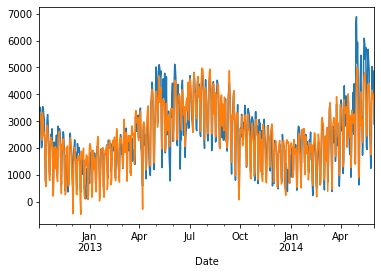

In [27]:
daily['total'].plot()
daily['final_trend'].plot()

rms=509


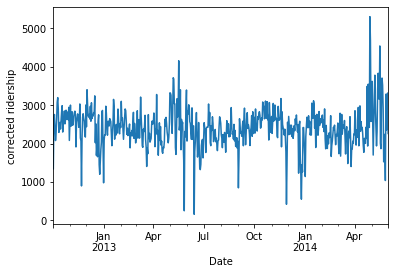

In [28]:
daily['final_corrected'].plot()
plt.ylabel('corrected ridership')
print('rms={0:.0f}'.format(np.std(daily['final_corrected'])))

In [30]:
vy=np.sum((y-daily['final_trend'])**2)/len(y)
X2=np.hstack([X,np.ones((X.shape[0],1))])
C=vy*np.linalg.inv(np.dot(X2.T,X2))
var=C.diagonal()

## What Can The Final Model Tell Us?

In [32]:
params=pd.Series(final_model.coef_,index=X.columns)
params

Mon          333.722933
Tues         537.066569
Wed          574.537503
Thurs        415.885963
Fri          177.791184
Sat         -994.182831
Sun        -1044.821321
daycount       0.631034
daylight     126.895905
TMIN         -41.615740
TMAX          66.188002
PRCP        -828.299464
dtype: float64

In [34]:
from sklearn.utils import resample
np.random.seed(1)
err=np.std([final_model.fit(*resample(X,y)).coef_
            for i in range(1000)],0)

In [35]:
print(pd.DataFrame({'effect':params.round(0),'error':err.round(0)}))

          effect  error
Mon        334.0   58.0
Tues       537.0   56.0
Wed        575.0   53.0
Thurs      416.0   50.0
Fri        178.0   57.0
Sat       -994.0   36.0
Sun      -1045.0   40.0
daycount     1.0    0.0
daylight   127.0   16.0
TMIN       -42.0    5.0
TMAX        66.0    4.0
PRCP      -828.0   79.0


We first see that there is a relatively stable trend in the weekly baseline: there are many more riders on weekdays than on weekends and holidays. We see that for each additional hour of daylight, 127 ± 16 more people choose to ride; a temperature increase of one degree Celsius encourages (66-42) ± (5+4) people to grab their bicycle; a dry day means an average of 548 ± 33 more riders, and each inch of precipitation means 665 ± 62 more people leave their bike at home. Once all these effects are accounted for, we see a modest increase of 27 ± 18 new daily riders each year.
Our model is almost certainly missing some relevant information. For example, nonlinear effects (such as effects of precipitation and cold temperature) and nonlinear trends within each variable (such as disinclination to ride at very cold and very hot temperatures) cannot be accounted for in this model. Additionally, we have thrown away some of the finer-grained information (such as the difference between a rainy morning and a rainy afternoon), and we have ignored correlations between days (such as the possible effect of a rainy Tuesday on Wednesday's numbers, or the effect of an unexpected sunny day after a streak of rainy days).